In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
from malaya_speech.utils.astype import float_to_int

`openai-whisper` is not available, native whisper processor is not available, will use huggingface processor instead.
`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [2]:
is_clean = malaya_speech.is_clean.nemo(model = 'huseinzol05/nemo-is-clean-titanet_large')
_ = is_clean.cuda()
_ = is_clean.eval()

Downloading:   0%|          | 0.00/2.87k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

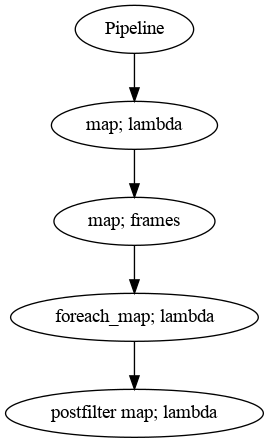

In [3]:
p_postfilter = Pipeline()
p_frames = p_postfilter.map(lambda x: malaya_speech.resample(x, old_samplerate = 44100, new_samplerate = 16000)) \
.map(malaya_speech.utils.generator.frames, frame_duration_ms = 100, 
                     append_ending_trail = False)
foreach = p_frames.foreach_map(lambda x: is_clean.predict_proba([x])[0,1])
# foreach.map(print)
foreach.map(lambda x: np.mean(x) > 0.3, name = 'postfilter')
p_postfilter.visualize()

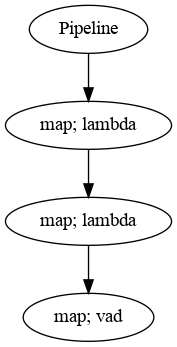

In [4]:
vad_model = malaya_speech.vad.webrtc()
p_vad = Pipeline()
pipeline = (
    p_vad.map(lambda x: malaya_speech.resample(x, old_samplerate = 44100, new_samplerate = 16000))
    .map(lambda x: float_to_int(x, divide_max_abs=False))
    .map(vad_model)
)
p_vad.visualize()

In [5]:
from glob import glob
from unidecode import unidecode
import os
import torchaudio
import torch

youtubes = sorted(glob('/home/ubuntu/server2/ssd2/podcast/*.mp3'))
len(youtubes)

332

In [6]:
(320 / 16000) * 44100

882.0

In [7]:
parent_dir = '/home/ubuntu/server2/ssd2/processed-podcast'
!rm -rf {parent_dir}
!mkdir {parent_dir}

parent_dir_done = '/home/ubuntu/server2/ssd2/processed-podcast-done'
!rm -rf {parent_dir_done}
!mkdir {parent_dir_done}

In [17]:
from tqdm import tqdm

for f in tqdm(youtubes):

    new_f = unidecode(os.path.split(f)[1].replace('.mp3', '').replace(' ', '_'))
    f_done = os.path.join(parent_dir_done, new_f)

    if os.path.exists(f_done):
        continue
        
    samples = malaya_speech.streaming.torchaudio.stream(f,
                                                    vad_model = p_vad, 
                                                    postfilter_model = p_postfilter,
                                                    segment_length = 882,
                                                    realtime_print = False,
                                                    sample_rate = 44100,
                                                    min_length = 2.0,
                                                    max_length = 15.0,
                                                   )
    if len(samples):
        parent_new_f = os.path.join(parent_dir, new_f)
        os.makedirs(parent_new_f, exist_ok=True)

        for i in range(len(samples)):
            audio_path = os.path.join(parent_new_f, f'{i}.mp3')
            torchaudio.save(audio_path, 
                            torch.tensor(samples[i]['wav_data'].astype('float32')).unsqueeze(0), 
                            44100, format='mp3')

    with open(f_done, 'w') as fopen:
        fopen.write('done')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332/332 [17:57:03<00:00, 194.65s/it]


In [19]:
mp3s = glob('/home/ubuntu/server2/ssd2/processed-podcast/*/*.mp3')
len(mp3s)

193410

In [20]:
from IPython.display import Audio 
Audio(mp3s[2])

In [22]:
from datasets import Audio

In [23]:
sr = 16000
audio = Audio(sampling_rate=sr)

from tqdm import tqdm

ls = 0
for x in tqdm(mp3s):
    ls += (len(audio.decode_example(audio.encode_example(x))['array']) / sr)

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 154924/193410 [13:33<04:01, 159.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
ls / 60 / 60

190.33451052081475